<a href="https://colab.research.google.com/github/pydevcasts/MLHub/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages: PyTorch, torchvision, and pytorch-fid for FID calculation
!pip install torch torchvision pytorch-fid

# Import necessary libraries
import os  # For interacting with the operating system
import torch  # Main PyTorch library
import torch.nn as nn  # For building neural network components
import torch.optim as optim  # For optimization algorithms
from torchvision import datasets, transforms  # For datasets and image transformations
from torch.utils.data import DataLoader  # For loading data in batches
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting images and graphs
from pytorch_fid import fid_score  # For calculating the Fréchet Inception Distance (FID)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the dimensionality of the latent space for the generator
# latent_dim = 64

# Set the batch size for training
batch_size = 128 #= [256, 128, 64, 32, 16, 8]

# Define the size of the images (e.g., for MNIST, images are 28x28 pixels)
image_size = 28

# Set the learning rate for the optimizer
lr = 0.0002

# Define the number of epochs for training the model
num_epochs = 20

In [ ]:
# Define a series of transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to the specified image size (28x28)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the images to have mean 0.5 and standard deviation 0.5
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for batching and shuffling the dataset
dataloader = DataLoader(dataset,
                        batch_size=batch_size,  # Set the batch size
                        shuffle=True,  # Shuffle the dataset for each epoch
                        drop_last=True  # Drop the last incomplete batch if it is smaller than batch_size
                        )

In [ ]:
print(latent_dim)
print(batch_size)


64
8


In [ ]:
# Define the Generator class, inheriting from nn.Module
class Generator(nn.Module):
    def __init__(self, latent_dim=64, img_channels=1, img_size=28):
        super().__init__()  # Initialize the base class

        # Define the model architecture as a sequential container
        self.model = nn.Sequential(
            # Layer 1: Map latent_dim to 512 units
            nn.Linear(latent_dim, 512),  # Fully connected layer from latent space to 512 units
            nn.BatchNorm1d(512),  # Batch normalization for stable training
            nn.ReLU(),  # ReLU activation function

            # Layer 2: Map 512 units to 64*8*8 units
            nn.Linear(512, 64 * 8 * 8),  # Fully connected layer to 64*8*8 units
            nn.BatchNorm1d(64 * 8 * 8),  # Batch normalization
            nn.ReLU(),  # ReLU activation function

            # Reshape to 3D tensor for convolutional layers
            nn.Unflatten(1, (64, 8, 8)),  # Reshape the output to (batch_size, 64, 8, 8)

            # First PixelShuffle: Upsample (64, 8, 8) to (16, 16, 16)
            nn.PixelShuffle(2),  # Rearranges elements in the tensor to increase spatial dimensions

            # Convolutional layer: Increase channels from 16 to 32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 2D convolution with 32 output channels
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),  # ReLU activation function

            # Second PixelShuffle: Upsample (32, 16, 16) to (8, 32, 32)
            nn.PixelShuffle(2),  # Further increases spatial dimensions while reducing channels

            # Final layers to produce the output image
            nn.Conv2d(8, img_channels, kernel_size=3, padding=1),  # Final convolution to produce the desired number of channels (e.g., 1 for grayscale)
            nn.Upsample(size=(img_size, img_size), mode='bilinear'),  # Upsample to the final image size (28x28)
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1 for pixel intensities
        )

    # Forward pass through the generator
    def forward(self, z):
        return self.model(z)  # Pass the input through the model

In [ ]:
print(latent_dim)
print(batch_size)
# print(real_images.size(0))

64
8


In [ ]:

# Define the Discriminator class, inheriting from nn.Module
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize the base class

        # Define the model architecture as a sequential container
        self.main = nn.Sequential(
            # First convolutional layer: 1 input channel -> 32 output channels
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output size: 32x14x14
            nn.ReLU(),  # ReLU activation function

            # Second convolutional layer: 32 input channels -> 64 output channels
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output size: 64x7x7
            nn.ReLU(),  # ReLU activation function

            # Flatten the output for the fully connected layers
            nn.Flatten(),  # Convert the 3D tensor to a 1D tensor

            # First fully connected layer: 64*7*7 inputs -> 512 outputs
            nn.Linear(64 * 7 * 7, 512),  # The input size must match the flattened output
            nn.ReLU(),  # ReLU activation function

            # Second fully connected layer: 512 inputs -> 1 output
            nn.Linear(512, 1),  # Final layer outputs a single value (real or fake)

            # Sigmoid activation to output a probability between 0 and 1
            nn.Sigmoid()  # This is used to produce a probability score for the input
        )

    # Forward pass through the discriminator
    def forward(self, x):
        return self.main(x)  # Pass the input through the model

In [ ]:
print(latent_dim)
print(batch_size)
# print(real_images.size(0))

64
8


### تابع خطا (Non-Saturating Loss):

In [ ]:
# Define the loss functions for the generator and discriminator
def generator_loss(fake_output):
    # Non-saturating loss for the generator
    return -torch.mean(torch.log(fake_output))

def discriminator_loss(real_output, fake_output):
    # Non-saturating loss for the discriminator
    real_loss = -torch.mean(torch.log(real_output))  # Loss for real images
    fake_loss = -torch.mean(torch.log(1 - fake_output))  # Loss for fake images
    return real_loss + fake_loss  # Total loss for the discriminator

# Initialize the generator and discriminator models and move them to the specified device (GPU or CPU)
generator = Generator().to(device)  # Create and move the generator to the device
discriminator = Discriminator().to(device)  # Create and move the discriminator to the device

# Initialize optimizers for both models
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for the generator
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for the discriminator

In [ ]:
print(latent_dim)
print(batch_size)
# print(real_images.size(0))

64
8


In [ ]:

# 7. Training Loop
g_losses = []  # List to store generator loss values
d_losses = []  # List to store discriminator loss values

# Define epochs to save generated images: initial, mid, and final
save_epochs = [1, num_epochs // 2, num_epochs]  # Save generated images at the beginning, middle, and end of training

# Loop through each epoch
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        # (a) Train the Discriminator
        discriminator.zero_grad()  # Reset gradients for the discriminator
        real_images = images.to(device)  # Move real images to the specified device
        batch_size = real_images.size(0)  # Get the batch size

        # 1. Generate fake images
        z = torch.randn(batch_size, latent_dim, device=device)  # Sample random latent vectors
        fake_images = generator(z)  # Generate fake images using the generator

        # 2. Calculate discriminator output for real and fake images
        real_output = discriminator(real_images).squeeze()  # Get discriminator output for real images
        fake_output = discriminator(fake_images.detach()).squeeze()  # Get output for fake images (detach to avoid backpropagation through generator)

        # 3. Compute discriminator loss and update
        d_loss = discriminator_loss(real_output, fake_output)  # Compute discriminator loss
        d_loss.backward()  # Backpropagate the loss
        optimizer_D.step()  # Update the discriminator's parameters

        # (b) Train the Generator
        generator.zero_grad()  # Reset gradients for the generator
        # Generate fake images again
        z = torch.randn(batch_size, latent_dim, device=device)  # Sample random latent vectors
        fake_images = generator(z)  # Generate new fake images

        # Compute discriminator output for fake images
        fake_output = discriminator(fake_images).squeeze()  # Get output for fake images

        # Compute generator loss and update
        g_loss = generator_loss(fake_output)  # Compute generator loss
        g_loss.backward()  # Backpropagate the loss
        optimizer_G.step()  # Update the generator's parameters

        # Save loss values
        g_losses.append(g_loss.item())  # Append generator loss to the list
        d_losses.append(d_loss.item())  # Append discriminator loss to the list

        # Print loss values every 200 steps
        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], "
                f"Loss_G: {g_loss.item():.4f}, Loss_D: {d_loss.item():.4f}"
            )

    # (c) Save a sample of generated images at initial, mid, and final stages
    if (epoch + 1) in save_epochs:
        with torch.no_grad():  # Disable gradient calculation for inference
            z = torch.randn(10 * 10, latent_dim, device=device)  # Generate a grid of latent vectors
            generated_images = generator(z).cpu()  # Generate images and move to CPU for visualization

            # Visualize the generated images
            fig, axs = plt.subplots(10, 10, figsize=(10, 10))  # Create a 10x10 grid of subplots
            for i in range(10):
                for j in range(10):
                    img_idx = i * 10 + j  # Calculate index for the image
                    axs[i, j].imshow(generated_images[img_idx].squeeze(), cmap='gray')  # Display the image
                    axs[i, j].axis('off')  # Hide the axes

            # Save the generated images to a file
            plt.savefig(os.path.join('./', f"generated_images_epoch_{epoch + 1}.png"))
            print(f"Generated images saved for epoch {epoch + 1}")
            plt.close(fig)  # Close the figure to free up memory

Epoch [1/5], Step [200/7500], Loss_G: 9.4934, Loss_D: 0.0001
Epoch [1/5], Step [400/7500], Loss_G: 11.3826, Loss_D: 0.0000
Epoch [1/5], Step [600/7500], Loss_G: 11.9009, Loss_D: 0.0000
Epoch [1/5], Step [800/7500], Loss_G: 12.3843, Loss_D: 0.0000
Epoch [1/5], Step [1000/7500], Loss_G: 12.6380, Loss_D: 0.0000
Epoch [1/5], Step [1200/7500], Loss_G: 13.1102, Loss_D: 0.0000
Epoch [1/5], Step [1400/7500], Loss_G: 12.1806, Loss_D: 0.0000
Epoch [1/5], Step [1600/7500], Loss_G: 12.5795, Loss_D: 0.0000
Epoch [1/5], Step [1800/7500], Loss_G: 12.8093, Loss_D: 0.0000
Epoch [1/5], Step [2000/7500], Loss_G: 13.0404, Loss_D: 0.0000
Epoch [1/5], Step [2200/7500], Loss_G: 13.2403, Loss_D: 0.0000
Epoch [1/5], Step [2400/7500], Loss_G: 13.4672, Loss_D: 0.0000
Epoch [1/5], Step [2600/7500], Loss_G: 13.6824, Loss_D: 0.0000
Epoch [1/5], Step [2800/7500], Loss_G: 13.9112, Loss_D: 0.0000
Epoch [1/5], Step [3000/7500], Loss_G: 14.1199, Loss_D: 0.0000
Epoch [1/5], Step [3200/7500], Loss_G: 14.3226, Loss_D: 0.00

Loss plot saved


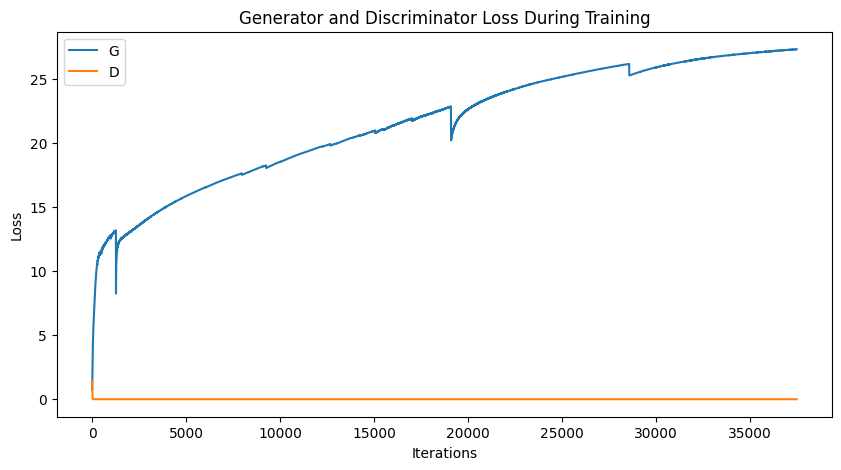

In [ ]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# (d) Plotting the Loss
plt.figure(figsize=(10, 5))  # Create a new figure with specified size
plt.title("Generator and Discriminator Loss During Training")  # Set the title of the plot
plt.plot(g_losses, label="G")  # Plot generator loss with label "G"
plt.plot(d_losses, label="D")  # Plot discriminator loss with label "D"
plt.xlabel("Iterations")  # Label for the x-axis
plt.ylabel("Loss")  # Label for the y-axis
plt.legend()  # Show legend to identify G and D

# Save the loss plot to a file
plt.savefig(os.path.join('./', "loss_plot.png"))
print("Loss plot saved")  # Print a confirmation message

plt.show()  # Display the plot

In [ ]:
print(latent_dim)
print(batch_size)
print(real_images.size(0))

64
8
8


In [ ]:

# Create real images directory
os.makedirs("./real_images", exist_ok=True)
for i, (img, _) in enumerate(dataset):
    if i >= 5000:
        break
    plt.imsave(f"./real_images/{i}.png", img.squeeze().numpy(), cmap='gray')


fake_images = []
for _ in range(100):  # 100 * batch_size = 12800 > 5000
    z = torch.randn(batch_size,latent_dim,).to(device)
    fake = generator(z).cpu().detach()
    print(fake.shape)
    fake_images.append(fake)
fake_images = torch.cat(fake_images)[:5000]  # انتخاب 5000 نمونه

# ذخیره در پوشه
os.makedirs("./fake_images", exist_ok=True)
for i, img in enumerate(fake_images):
    plt.imsave(f"./fake_images/{i}.png", img.squeeze(), cmap='gray')
# Verify paths
print(f"Real images: {len(os.listdir('./real_images'))}")
print(f"Fake images: {len(os.listdir('./fake_images'))}")

# Calculate FID
fid_value = fid_score.calculate_fid_given_paths(
    ["./real_images", "./fake_images"],
    batch_size=50,
    device=device,
    dims=2048
)
print(f"FID Score: {fid_value:.2f}")

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
t

100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


FID Score: 287.96


In [ ]:
print(f"real_images.shape: {real_images.shape}")
print(f"fake_images.shape: {fake_images.shape}")

real_images.shape: torch.Size([8, 1, 28, 28])
fake_images.shape: torch.Size([800, 1, 28, 28])


In [ ]:
print(latent_dim)
print(batch_size)
print(real_images.size(0))

64
8
8


In [ ]:
import torch.autograd as autograd

# Function to compute the gradient penalty
def gradient_penalty(critic, real_images, fake_images, device):
    batch_size = real_images.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)  # Randomly sample alpha values

    # Create interpolates between real and fake images
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)

    # Get the critic's output for the interpolated images
    critic_interpolates = critic(interpolates)

    # Compute gradients of the critic's output with respect to the interpolates
    gradients = autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),  # Gradient of outputs w.r.t. the critic's output
        create_graph=True,  # Allow gradients to be computed for higher order
        retain_graph=True,  # Retain the graph for further backward passes
    )[0]

    # Reshape gradients to be of shape (batch_size, -1)
    gradients = gradients.view(gradients.size(0), -1)

    # Compute the gradient penalty
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # Penalty term for WGAN-GP
    return penalty  # Return the computed gradient penalty
# Function to compute the discriminator's loss
def discriminator_loss(real_scores, fake_scores, gp, lambda_gp=10):
    # WGAN-GP loss for the discriminator/critic
    return -torch.mean(real_scores) + torch.mean(fake_scores) + lambda_gp * gp
    # -mean(real_scores): Encourages the critic to output higher scores for real images
    # mean(fake_scores): Encourages the critic to output lower scores for fake images
    # lambda_gp * gp: Adds the gradient penalty to stabilize training

# Function to compute the generator's loss
def generator_loss(fake_scores):
    # WGAN-GP loss for the generator
    return -torch.mean(fake_scores)  # Encourages the generator to produce images that get high scores from the critic

In [ ]:
import torch.nn as nn  # Import the PyTorch neural network module

### Cell 2: Define the architecture of the Critic (Discriminator)
class Critic(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize the base class

        # Define the model architecture as a sequential container
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # First conv layer: 1 input channel -> 32 output channels
            nn.LeakyReLU(0.2),  # Leaky ReLU activation with negative slope 0.2

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Second conv layer: 32 -> 64 channels
            nn.LeakyReLU(0.2),  # Leaky ReLU activation

            nn.Flatten(),  # Flatten the output from the conv layers for the fully connected layers

            nn.Linear(64 * 7 * 7, 512),  # First fully connected layer: 64*7*7 inputs -> 512 outputs
            nn.LeakyReLU(0.2),  # Leaky ReLU activation

            nn.Linear(512, 1)  # Final layer outputs a single score (critic's score for the input)
            # Note: No Sigmoid activation here, as WGAN uses raw scores for the Wasserstein distance
        )

    def forward(self, x):
        return self.main(x)  # Pass the input through the defined architecture

In [ ]:
n_critic = 7  # کمتر کردن تعداد آموزش Critic
lambda_gp = 10  # مقدار معمول
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        # Train the Critic
        for _ in range(n_critic):
            optimizer_D.zero_grad()

            # Generate fake images
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_images = generator(z)

            # Compute the gradient penalty
            gp = gradient_penalty(discriminator, real_images, fake_images, device)

            # Compute the Critic's scores for real and fake images
            real_scores = discriminator(real_images)
            fake_scores = discriminator(fake_images)

            # Compute the Critic loss
            d_loss = discriminator_loss(real_scores, fake_scores, gp, lambda_gp)

            # Backpropagate and optimize the Critic
            d_loss.backward()
            optimizer_D.step()

            d_losses.append(d_loss.item())

        # Train the Generator
        optimizer_G.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        fake_scores = discriminator(fake_images)

        # Compute the Generator loss
        g_loss = generator_loss(fake_scores)

        # Backpropagate and optimize the Generator
        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())

        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], "
                f"Loss_D: {d_loss.item():.4f}, Loss_G: {g_loss.item():.4f}"
            )

Epoch [1/5], Step [200/7500], Loss_D: -0.3996, Loss_G: -0.0593
Epoch [1/5], Step [400/7500], Loss_D: -0.5999, Loss_G: -0.0477
Epoch [1/5], Step [600/7500], Loss_D: -0.7154, Loss_G: -0.0348
Epoch [1/5], Step [800/7500], Loss_D: -0.8352, Loss_G: -0.0100
Epoch [1/5], Step [1000/7500], Loss_D: -0.8087, Loss_G: -0.0223
Epoch [1/5], Step [1200/7500], Loss_D: -0.7688, Loss_G: -0.0416
Epoch [1/5], Step [1400/7500], Loss_D: -0.7955, Loss_G: -0.0114
Epoch [1/5], Step [1600/7500], Loss_D: -0.8327, Loss_G: -0.0078
Epoch [1/5], Step [1800/7500], Loss_D: -0.7931, Loss_G: -0.0181
Epoch [1/5], Step [2000/7500], Loss_D: -0.8278, Loss_G: -0.0218
Epoch [1/5], Step [2200/7500], Loss_D: -0.8588, Loss_G: -0.0152
Epoch [1/5], Step [2400/7500], Loss_D: -0.8840, Loss_G: -0.0135
Epoch [1/5], Step [2600/7500], Loss_D: -0.7475, Loss_G: -0.0194
Epoch [1/5], Step [2800/7500], Loss_D: -0.8948, Loss_G: -0.0136
Epoch [1/5], Step [3000/7500], Loss_D: -0.9161, Loss_G: -0.0059
Epoch [1/5], Step [3200/7500], Loss_D: -0.87

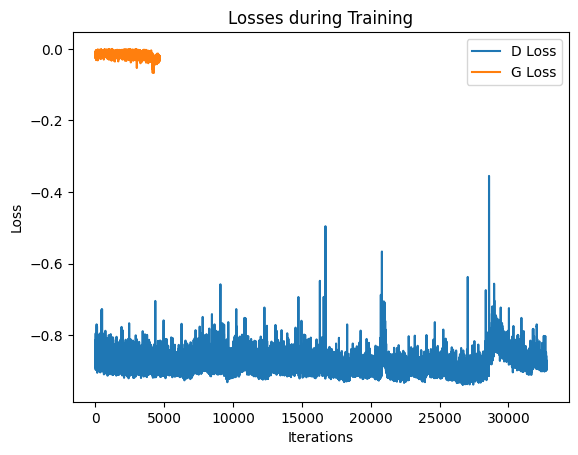

In [ ]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Plotting the losses
plt.plot(d_losses, label='D Loss')  # Plot the Discriminator loss
plt.plot(g_losses, label='G Loss')  # Plot the Generator loss
plt.xlabel('Iterations')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Show legend to differentiate between D and G losses
plt.title('Losses during Training')  # Set the title of the plot
plt.show()  # Display the plot

In [ ]:
print(latent_dim)
print(batch_size)
print(real_images.size(0))

64
64
256


In [ ]:
# مسیر پوشه‌های تصاویر واقعی و ساختگی
real_images_path = "./real_images"
fake_images_path = "./fake_images"

# محاسبه FID
fid_value = fid_score.calculate_fid_given_paths(
    [real_images_path, fake_images_path],
    batch_size=50,
    device=device,  # مثلاً 'cuda' یا 'cpu'
    dims=2048
)

print(f"FID Score: {fid_value:.2f}")

100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


FID Score: 281.44


In [ ]:

### Cell 4: Define Residual Block for Generator
class ResidualBlockG(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=True):
        super().__init__()
        self.upsample = upsample  # Flag to determine whether to upsample

        # Define the main block of the residual block
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Upsample(scale_factor=2, mode='nearest') if upsample else nn.Identity(),  # Upsampling if needed
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # First convolution
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # Second convolution
        )

        # Define the shortcut connection
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest') if upsample else nn.Identity(),  # Upsampling if needed
            nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 convolution for matching dimensions
        )

    def forward(self, x):
        # Return the sum of the main block output and the shortcut connection
        return self.block(x) + self.shortcut(x)


### Cell 5: Implement Generator with Architecture from Table 4
class SSGenerator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Initial layer to project the latent vector
        self.init_layer = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),  # Fully connected layer to expand latent vector
            nn.BatchNorm1d(256 * 4 * 4),  # Batch normalization
            nn.ReLU()  # ReLU activation
        )

        # Residual blocks to upscale and refine the generated images
        self.res_blocks = nn.Sequential(
            ResidualBlockG(256, 256, upsample=True),  # First residual block
            ResidualBlockG(256, 256, upsample=True),  # Second residual block
            ResidualBlockG(256, 256, upsample=True)   # Third residual block
        )

        # Final layers to produce the output image
        self.final_layers = nn.Sequential(
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Conv2d(256, 1, kernel_size=3, padding=1),  # Final convolution to reduce channels to 1 (grayscale image)
            nn.Tanh()  # Tanh activation to output values in the range [-1, 1]
        )

    def forward(self, z):
        # Forward pass through the generator
        x = self.init_layer(z)  # Pass latent vector through initial layer
        x = x.view(-1, 256, 4, 4)  # Reshape to (batch_size, channels, height, width)
        x = self.res_blocks(x)  # Pass through residual blocks
        return self.final_layers(x)  # Pass through final layers to get output image

In [ ]:
print(latent_dim)
print(batch_size)
print(real_images.size(0))

64
256
256
